In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [2]:
denoised = '_denoised'
# denoised = ''

read_path = f'/vast/xj2173/diffeo/scratch_data/steering/ENV2_s_NN{denoised}/'
ref_path  = f'/vast/xj2173/diffeo/scratch_data/steering/ENV2_s_NN{denoised}/reference/'
diffeo_path = '/home/xj2173/vast/diffeo/scratch_data/inv_diffeo_param/0-5-0-5-3-15-20'

read_path = f'/vast/xj2173/diffeo/scratch_data/steering/ENV2_s_no_steering/'
ref_path  = f'/vast/xj2173/diffeo/scratch_data/steering/ENV2_s_no_steering/reference/'
diffeo_path = '/home/xj2173/vast/diffeo/scratch_data/inv_diffeo_param/0-5-0-5-3-11-20-0.01'

In [3]:
steering_layers = list(range(3,14))
layers_in_string = '-'.join(str(num) for num in steering_layers)

ref_dir_list = [s for s in os.listdir(ref_path)]
ref_dir_list.sort()

data_dir_list = [s for s in os.listdir(read_path) if layers_in_string in s]
data_dir_list = [s for s in os.listdir(read_path) if 'reference' not in s]
data_dir_list.sort()
# data_dir_list

In [4]:
all_data = []
for dir in data_dir_list:
    all_data.append(torch.load(read_path + dir, map_location = torch.device('cpu'), weights_only=False))
all_data = torch.stack(all_data, dim = 0)

ref_data = torch.load(ref_path + ref_dir_list[0], map_location = torch.device('cpu'), weights_only=False)

diffeo_data = torch.load(diffeo_path, map_location = torch.device('cpu'), weights_only=False)

In [5]:
all_data.shape

torch.Size([100, 8, 20, 1000])

In [5]:
all_dot_product = torch.einsum('ilsdx, ix -> ilsd', F.normalize(all_data.unsqueeze(1), dim = -1), F.normalize(ref_data, dim = -1))
dot_product = torch.mean(all_dot_product, dim = (0,3))
err_bar = torch.std(all_dot_product, dim = (0,3))

In [6]:
diffeo_strengths = diffeo_data['diffeo_config']['strength']
print(diffeo_strengths)

[0, 1e-05, 2e-05, 5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]


Text(0.5, 1.0, 'near the origin the cosine similarity is constant')

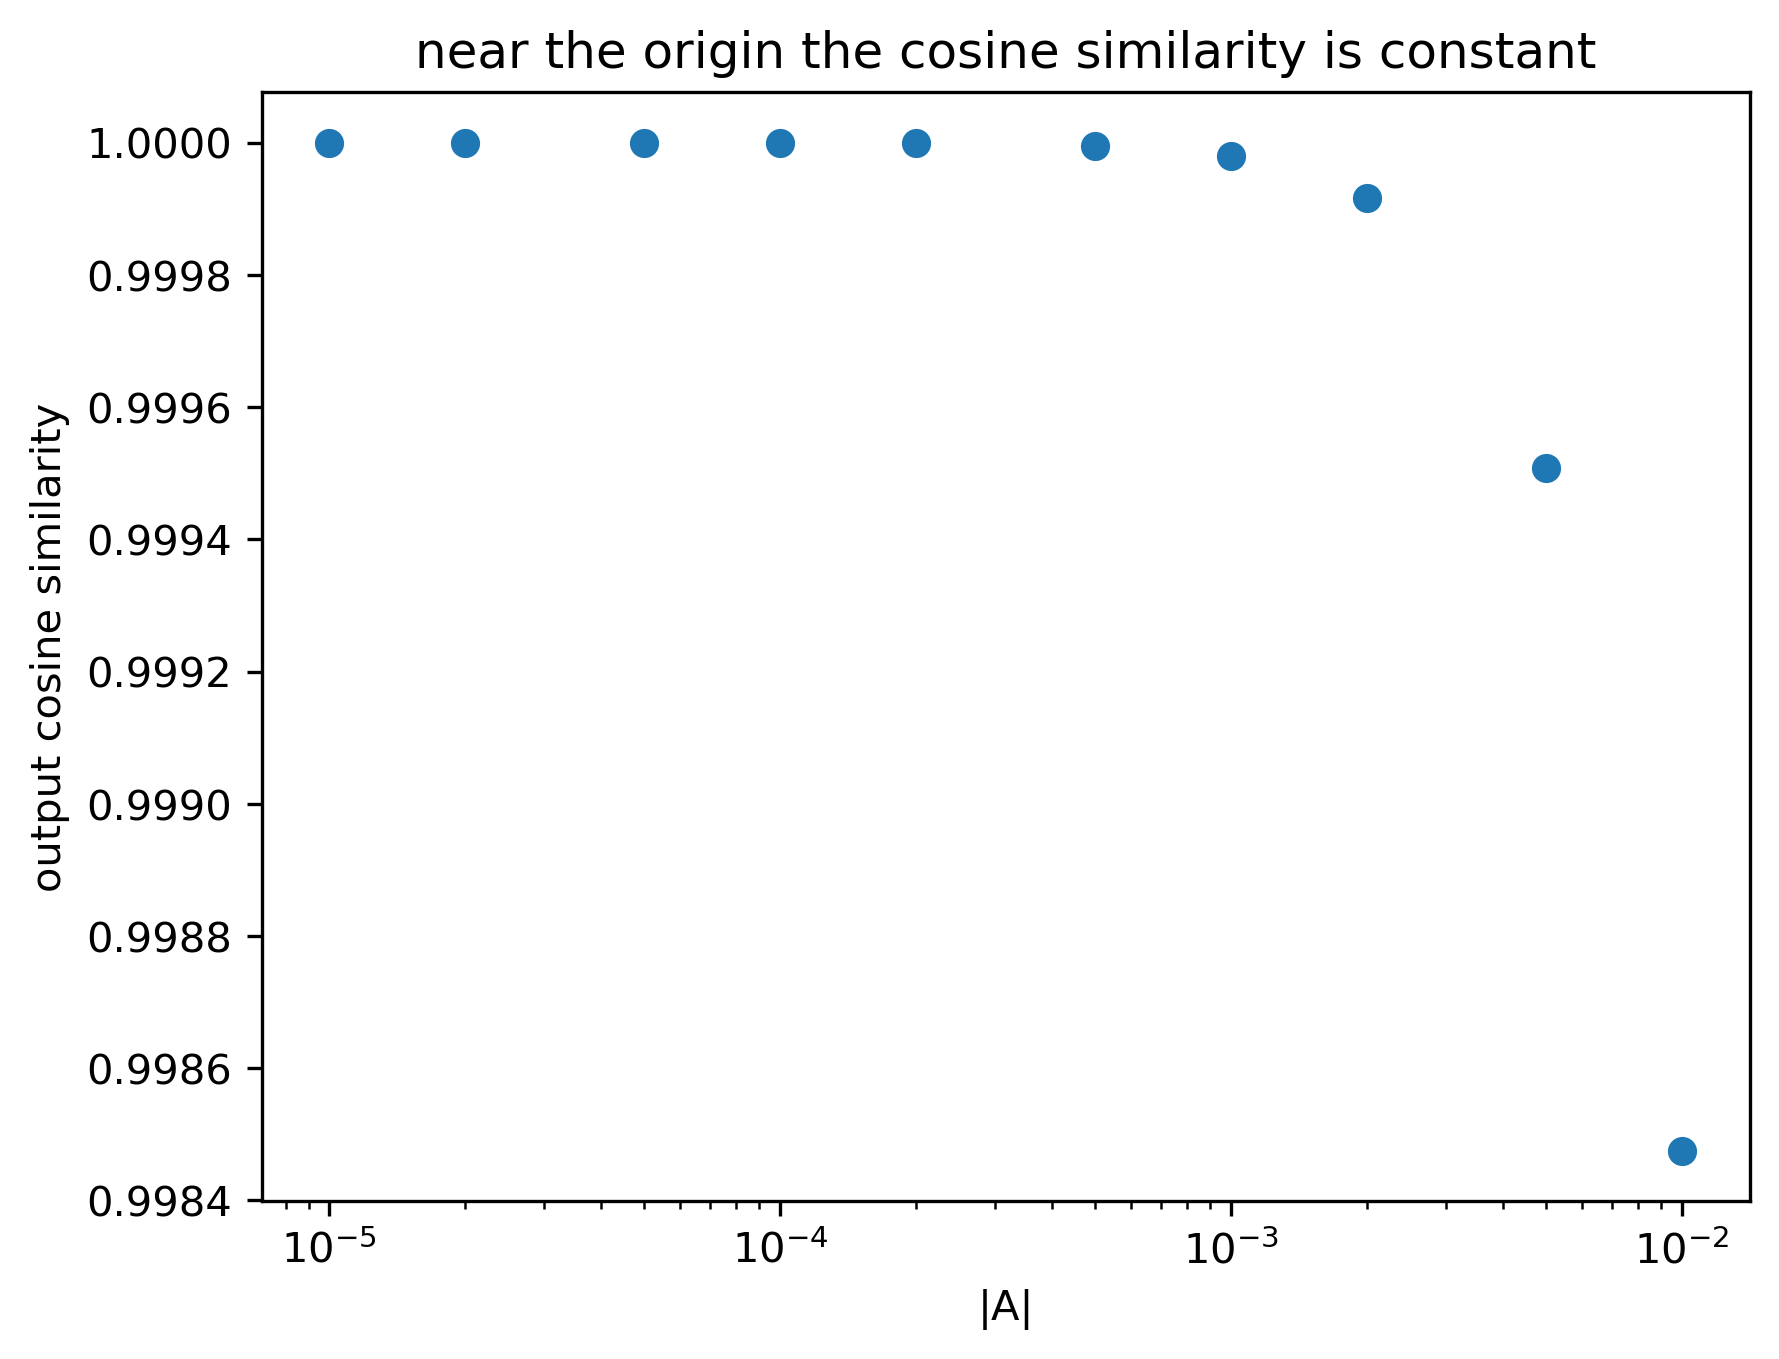

In [12]:
plt.figure(dpi = 300)
plt.scatter(diffeo_strengths, dot_product[0])
plt.xscale('log')
plt.xlabel(r'|A|')
plt.ylabel('output cosine similarity')
plt.title('near the origin the cosine similarity is constant')

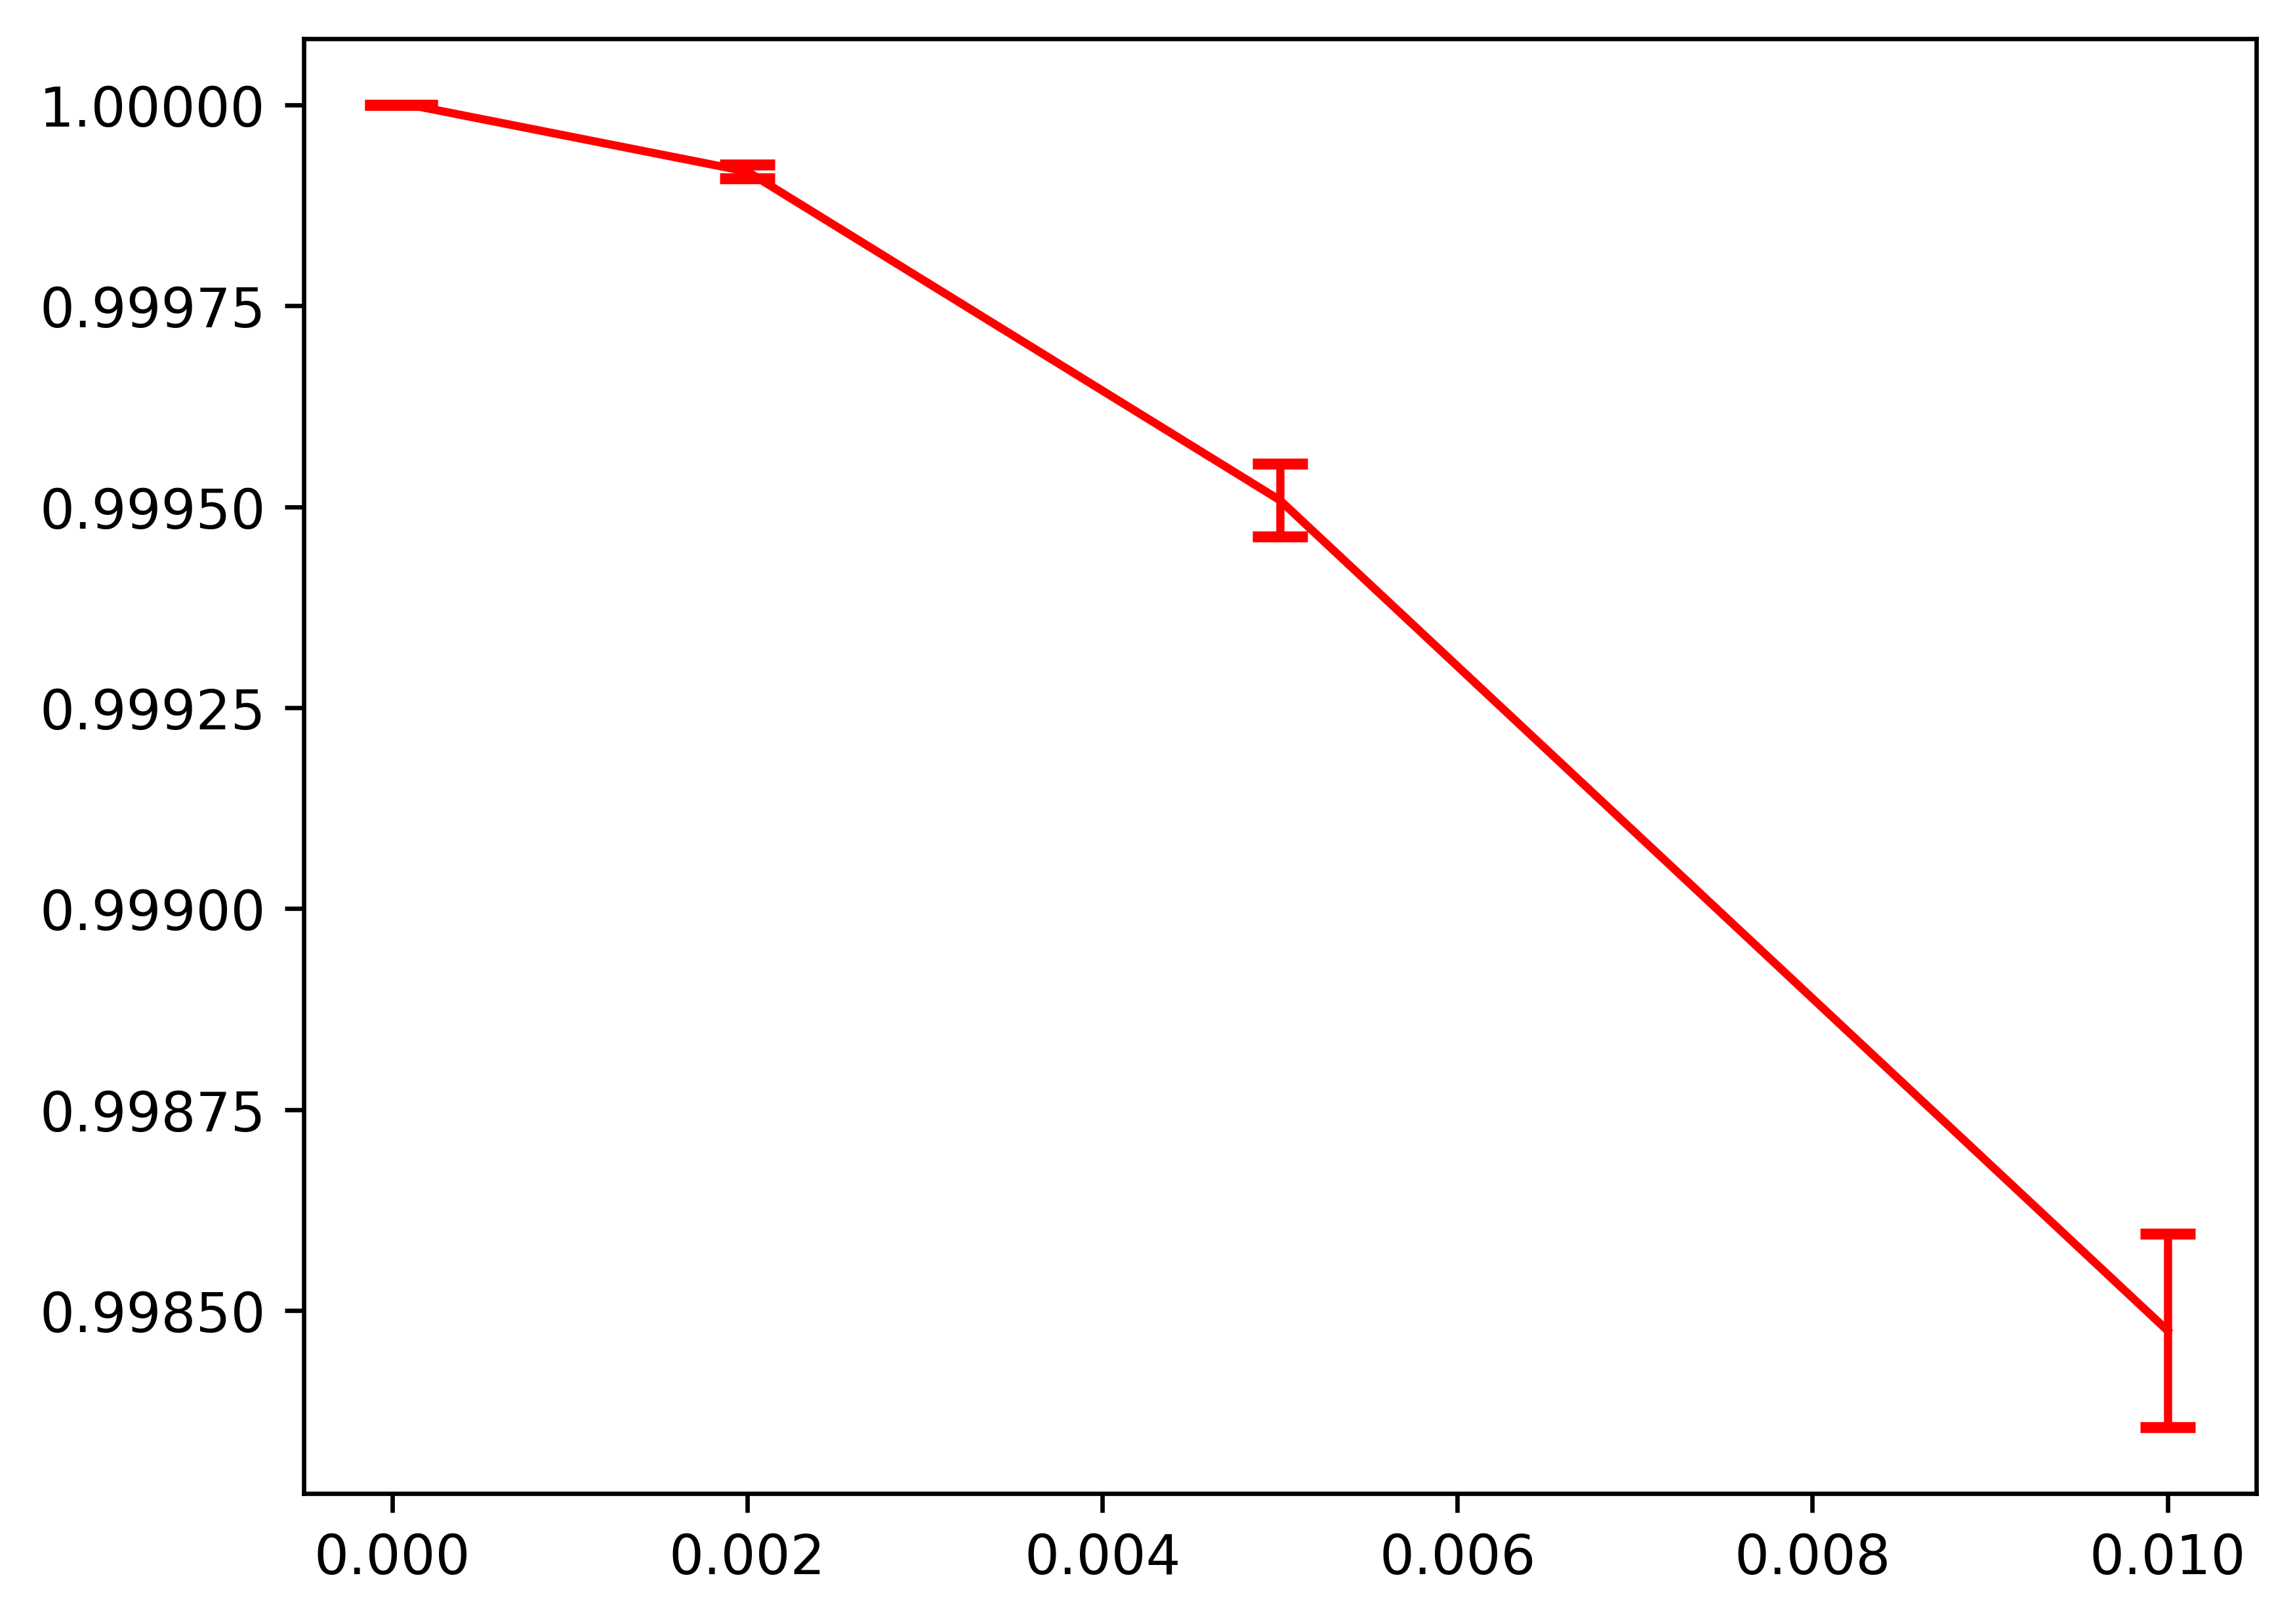

In [8]:
plt.figure(dpi = 600)

init_l = 6 - 3 + 1
fin_l  = 9 - 3 + 1 + 1


init_A = 0
fin_A = 15

colors = plt.cm.viridis_r(np.linspace(0,1,1 + len(dot_product[init_l:fin_l])))

plt.errorbar(diffeo_strengths[init_A:fin_A], dot_product[0][init_A:fin_A], err_bar[0][init_A:fin_A]/20, color='r', label = f'no steering', alpha = 1, capsize= 5, capthick= 2)

for i, (layer, error) in enumerate(zip(dot_product[init_l:fin_l], err_bar[init_l:fin_l])):
    layer_num = init_l + i + 3 - 1
    # if i != 0:
    plt.errorbar(diffeo_strengths[init_A:fin_A], layer[init_A:fin_A], error[init_A:fin_A]/20, color=colors[i], label = f'layer {layer_num}', alpha = 0.3, capsize= 5, capthick= 2)
    # plt.hlines(y = 1, xmin = diffeo_strengths[init_A], xmax = diffeo_strengths[fin_A - 1], color = 'r', linestyle = '--')
    plt.legend(bbox_to_anchor=(1,1))
    plt.legend(bbox_to_anchor=(1,1), ncol=1)
    plt.xlabel(r'diffeo strength w/ L1 norm $|A|_1$')
    plt.title(r'steered cosine similarity with $g^{-1}$')
    plt.ylabel(r'normalized averaged cosine similarity')

